# Results Analysis

In [1]:
import wandb 
import dataclasses
import pandas as pd

api = wandb.Api(timeout=100)

@dataclasses.dataclass
class Run:
    config: dict
    summary: dict


def get_runs_from_sweep(sweep):
    runs = []
    experiment_stats = {}

    for run in sweep.runs:
        # discard non-test metrics from each run
        summary = {k:v for k,v in run.summary.items() if "test" in k}
        runs.append(Run(run.config, summary))

    return runs


def get_df_from_runs(runs):
    df = pd.DataFrame([run.config | run.summary for run in runs])
    return df

def drop_unused_columns(df, mode: str):
    if mode == "predict_attr":
        for col in df.columns:
            if "test" in col and "auc" not in col:
                df.drop(col, axis=1, inplace=True)
    
    elif mode == "predict_disease":
        for col in df.columns:
            # drop all test metrics except test/accuracy and split_test/auc 
            if "test" in col and "accuracy" not in col and "split_test/auc" not in col:
                df.drop(col, axis=1, inplace=True)

    else:
        raise ValueError(f"Invalid mode: {mode}")

    return df

Get sweeps from wandb. We assume the sweeps are completed and no runs have crashed.

Make sure you have logged into wandb on the command line, then add the path to your sweeps below.

In [2]:
predict_attr_sweep_id = "<WANDB_USERNAME/subgroup_separability/<SWEEP_ID>"
predict_attr_sweep = api.sweep(predict_attr_sweep_id)
predict_attr_runs = get_runs_from_sweep(predict_attr_sweep)

predict_attr_df = get_df_from_runs(predict_attr_runs)
predict_attr_df = drop_unused_columns(predict_attr_df, mode="predict_attr")
print(predict_attr_df.shape)
predict_attr_df.head()

(110, 6)


,rng,model,experiment,model.predict_attr,datamodule.label_noise,test/auc
0,800,baseline,fitzpatrick17k_skin,True,0,0.888430
1,700,baseline,fitzpatrick17k_skin,True,0,0.896807
2,600,baseline,fitzpatrick17k_skin,True,0,0.900844
3,500,baseline,fitzpatrick17k_skin,True,0,0.894457
4,400,baseline,fitzpatrick17k_skin,True,0,0.895530


In [3]:
predict_disease_sweep_id = "<WANDB_USERNAME>/subgroup_separability/<SWEEP_ID>"
predict_disease_sweep = api.sweep(predict_disease_sweep_id)
predict_disease_runs = get_runs_from_sweep(predict_disease_sweep)

predict_disease_df = get_df_from_runs(predict_disease_runs)
predict_disease_df = drop_unused_columns(predict_disease_df, mode="predict_disease")
print(predict_disease_df.shape)
predict_disease_df.head()

(220, 9)


,rng,model,experiment,model.predict_attr,datamodule.label_noise,test/accuracy_group_1,test/accuracy_group_0,split_test/accuracy,split_test/auc
0,800,baseline,fitzpatrick17k_skin,False,0.25,0.913131,0.874435,0.812110,0.863272
1,700,baseline,fitzpatrick17k_skin,False,0.25,0.933333,0.888889,0.803995,0.848910
2,600,baseline,fitzpatrick17k_skin,False,0.25,0.931313,0.891599,0.802747,0.849104
3,500,baseline,fitzpatrick17k_skin,False,0.25,0.923232,0.887986,0.795880,0.842655
4,400,baseline,fitzpatrick17k_skin,False,0.25,0.927273,0.886179,0.780899,0.829290


Analyse the predict_attr results

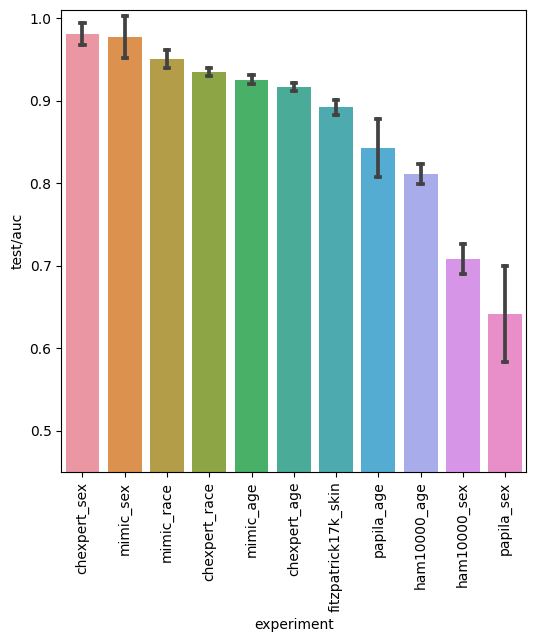

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1, figsize=(6, 6))

sns.barplot(
    data=predict_attr_df,
    x="experiment",
    y="test/auc",
    errorbar="sd",
    order=predict_attr_df.groupby("experiment")
        .agg({"test/auc": "mean"})
        .sort_values("test/auc", ascending=False)
        .index,
    capsize=0.1,
    ax=axs
)
axs.set_ylim(0.45, 1.01)
axs.set_xticklabels(predict_attr_df.groupby("experiment")
        .agg({"test/auc": "mean"})
        .sort_values("test/auc", ascending=False)
        .index, rotation=90
        )

plt.show()



In [5]:
attr_results_agg = predict_attr_df.groupby("experiment").agg(
    {"test/auc": ["mean", "std"]}
).sort_values(("test/auc", "mean"), ascending=False)
attr_results_agg

test/auc          
                         mean       std
experiment                             
chexpert_sex         0.981253  0.013391
mimic_sex            0.977491  0.025314
mimic_race           0.950537  0.010487
chexpert_race        0.934766  0.004983
mimic_age            0.925658  0.005218
chexpert_age         0.916360  0.004866
fitzpatrick17k_skin  0.892136  0.009207
papila_age           0.842624  0.034641
ham10000_age         0.811356  0.012306
ham10000_sex         0.708201  0.018008
papila_sex           0.641825  0.058418

Now, analyse results for predicting disease (ERM only)

In [6]:
disease_results_df = predict_disease_df
disease_results_df.head()

,rng,model,experiment,model.predict_attr,datamodule.label_noise,test/accuracy_group_1,test/accuracy_group_0,split_test/accuracy,split_test/auc
0,800,baseline,fitzpatrick17k_skin,False,0.25,0.913131,0.874435,0.812110,0.863272
1,700,baseline,fitzpatrick17k_skin,False,0.25,0.933333,0.888889,0.803995,0.848910
2,600,baseline,fitzpatrick17k_skin,False,0.25,0.931313,0.891599,0.802747,0.849104
3,500,baseline,fitzpatrick17k_skin,False,0.25,0.923232,0.887986,0.795880,0.842655
4,400,baseline,fitzpatrick17k_skin,False,0.25,0.927273,0.886179,0.780899,0.829290


In [7]:
# split into noise and no noise and aggregate by experiment

noise_df = disease_results_df[disease_results_df["datamodule.label_noise"] > 0]
no_noise_df = disease_results_df[disease_results_df["datamodule.label_noise"] == 0]

noise_df_agg = noise_df.groupby("experiment").agg(
    {"test/accuracy_group_0": ["mean", "std"], "test/accuracy_group_1": ["mean", "std"], 
     "split_test/auc": ["mean", "std"]
    }
    )
noise_df_agg.columns = ["_".join(col) for col in noise_df_agg.columns]
no_noise_df_agg = no_noise_df.groupby("experiment").agg(
    {"test/accuracy_group_0": ["mean", "std"], "test/accuracy_group_1": ["mean", "std"],
     "split_test/auc": ["mean", "std"]
     }
    )

no_noise_df_agg.columns = ["_".join(col) for col in no_noise_df_agg.columns]

print(noise_df_agg.shape)
noise_df_agg.head()

(11, 6)


,test/accuracy_group_0_mean,test/accuracy_group_0_std,test/accuracy_group_1_mean,test/accuracy_group_1_std,split_test/auc_mean,split_test/auc_std
experiment,,,,,,
chexpert_age,0.837813,0.016208,0.914672,0.011841,0.857236,0.010204
chexpert_race,0.878502,0.034615,0.837149,0.043033,0.852563,0.013014
chexpert_sex,0.840685,0.056867,0.785013,0.069790,0.939627,0.020038
fitzpatrick17k_skin,0.884553,0.006094,0.925657,0.006653,0.851455,0.010869
ham10000_age,0.913140,0.009776,0.774194,0.014633,0.778130,0.016362


In [8]:
# subtract no_noise results from noise results to get the difference
# we assume that the results are independent, hence we use the formula 
# for the std of the difference of two independent RVs
# negative difference means results have deteriorated
# we additionally multiply by 100 to convert accuracy to percentage points

import numpy as np
from scipy import stats


diff_df = pd.DataFrame()
diff_df["experiment"] = noise_df_agg.index

for col in noise_df_agg.columns:
    if "mean" in col and "split" not in col:
        diff_df[col] = 100 * (noise_df_agg[col].values - no_noise_df_agg[col].values)

    if "std" in col and "split" not in col:
        # std of subtracted independent RVs is sqrt of sum of squares of stds
        diff_df[col] = 100 * np.sqrt(noise_df_agg[col].values**2 + no_noise_df_agg[col].values**2)


# perform Mann-Whitney U test for each experiment
u_results_group_0 = {}
u_results_group_1 = {}

for experiment in diff_df["experiment"].unique():
    u_results_group_0[experiment] = stats.mannwhitneyu(
        no_noise_df[no_noise_df["experiment"] == experiment]["test/accuracy_group_0"].values,
        noise_df[noise_df["experiment"] == experiment]["test/accuracy_group_0"].values,
        alternative="greater"
    )
    u_results_group_1[experiment] = stats.mannwhitneyu(
        no_noise_df[no_noise_df["experiment"] == experiment]["test/accuracy_group_1"].values,
        noise_df[noise_df["experiment"] == experiment]["test/accuracy_group_1"].values,
        alternative="greater"
    )

diff_df["u_group_0"] = diff_df["experiment"].map(
    {experiment: u_results_group_0[experiment].statistic for experiment in diff_df["experiment"].unique()})

diff_df["u_group_1"] = diff_df["experiment"].map(
    {experiment: u_results_group_1[experiment].statistic for experiment in diff_df["experiment"].unique()})
diff_df["p_group_0"] = diff_df["experiment"].map(
    {experiment: u_results_group_0[experiment].pvalue for experiment in diff_df["experiment"].unique()})
diff_df["p_group_1"] = diff_df["experiment"].map(
    {experiment: u_results_group_1[experiment].pvalue for experiment in diff_df["experiment"].unique()})


# adjust for multiple testing with holm-bonferroni
# add columns with adjusted p-values, calculated by sorting p-values,
# multiplying the smallest by the number of tests, 
# second smallest by the number of tests minus 1, etc.
diff_df["p_group_0_adj"] = diff_df.sort_values("p_group_0")["p_group_0"] * np.flip(np.arange(1, len(diff_df) + 1))
diff_df["p_group_1_adj"] = diff_df.sort_values("p_group_1")["p_group_1"] * np.flip(np.arange(1, len(diff_df) + 1))
 

# add columns with predict_attr results
diff_df["predict_attr_mean"] = diff_df["experiment"].map(
    attr_results_agg[("test/auc", "mean")]
)
diff_df["predict_attr_std"] = diff_df["experiment"].map(
    attr_results_agg[("test/auc", "std")]
)

# sort rows by predict_attr results
diff_df = diff_df.sort_values("predict_attr_mean", ascending=True)


# rename experiments from snake_case to Kebab-Case, capitalize first letter and after hyphen
diff_df["experiment"] = diff_df["experiment"].map(
    {experiment: experiment.replace("_", "\n").title() for experiment in diff_df["experiment"].unique()}
)

# rename Mimic to MIMIC, Papila to PAPILA, and Ham10000 to HAM10000, Chexpert to CheXpert
diff_df["experiment"] = diff_df["experiment"].map(
    {experiment: experiment.replace("Mimic", "MIMIC").replace("Papila", "PAPILA").replace("Ham10000", "HAM10000").replace("Chexpert", "CheXpert") for experiment in diff_df["experiment"].unique()}
)


diff_df

,experiment,test/accuracy_group_0_mean,test/accuracy_group_0_std,test/accuracy_group_1_mean,test/accuracy_group_1_std,u_group_0,u_group_1,p_group_0,p_group_1,p_group_0_adj,p_group_1_adj,predict_attr_mean,predict_attr_std
10,PAPILA\nSex,1.666666,31.279306,-1.714285,8.754655,48.5,59.0,0.561453,0.258358,0.561453,1.033431,0.641825,0.058418
5,HAM10000\nSex,-1.012890,4.880855,-0.871460,3.824342,59.5,54.5,0.247251,0.380397,1.978005,0.760794,0.708201,0.018008
4,HAM10000\nAge,-0.276625,1.317967,-1.397851,2.231645,57.5,73.5,0.297866,0.040244,1.787196,0.241465,0.811356,0.012306
9,PAPILA\nAge,0.714285,11.459943,3.043478,13.556730,56.5,39.0,0.322885,0.811948,1.291541,0.811948,0.842624,0.034641
3,Fitzpatrick17K\nSkin,-0.081302,0.927363,-0.101010,1.122178,57.0,55.5,0.310601,0.352091,1.553004,1.056273,0.892136,0.009207
0,CheXpert\nAge,-0.144396,2.882837,-0.940839,1.831183,55.0,73.0,0.366865,0.044487,1.100595,0.222433,0.916360,0.004866
6,MIMIC\nAge,-1.122438,3.117268,-4.513497,3.557757,65.0,90.0,0.136518,0.001414,1.228664,0.012723,0.925658,0.005218
1,CheXpert\nRace,-1.465287,3.812727,-4.502144,4.602745,58.0,88.0,0.285375,0.002293,1.997626,0.018346,0.934766,0.004983
7,MIMIC\nRace,-0.180433,3.316903,-3.379197,3.765391,52.0,79.5,0.454861,0.014123,0.909722,0.098863,0.950537,0.010487
8,MIMIC\nSex,-2.957016,4.256149,-8.164665,4.485069,74.0,96.0,0.037831,0.000291,0.378308,0.003206,0.977491,0.025314


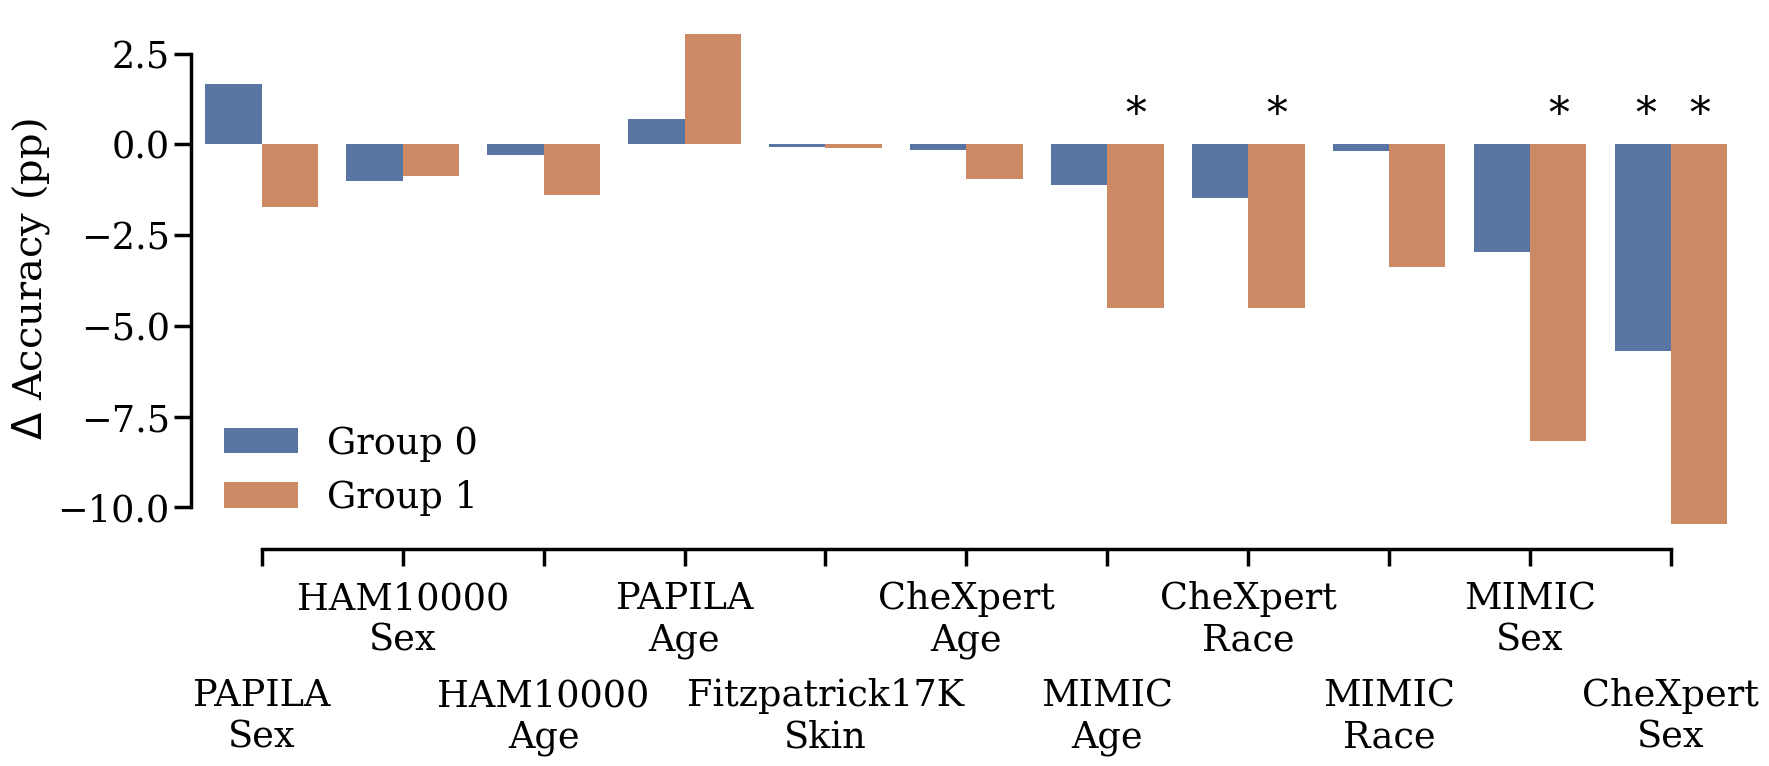

In [9]:
# massage data for plotting: combine accuracy columns,
# then create an indicator column for which accuracy group the row is for

plt.rcParams['font.family'] = "serif"
sns.set_context("poster", font_scale=1.2)
fig, axs = plt.subplots(1, 1, figsize=(20, 7))

plot_diff_df = diff_df.melt(
    id_vars=["experiment", "predict_attr_mean", "predict_attr_std"],
    value_vars=["test/accuracy_group_0_mean", "test/accuracy_group_1_mean"],
    var_name="group",
    value_name="accuracy"
)


sns.barplot(
    data=plot_diff_df,
    x="experiment",
    y="accuracy",
    hue="group",
    order=plot_diff_df.groupby("experiment").agg({"predict_attr_mean": "mean"})
        .sort_values("predict_attr_mean", ascending=True).index,
    ax=axs,
    palette="deep"
)

axs.set_xticklabels(plot_diff_df.groupby("experiment").agg({"predict_attr_mean": "mean"})
    .sort_values("predict_attr_mean", ascending=True).index, rotation=00)


sns.despine(fig=fig, ax=axs, trim=True)

axs.set_ylabel(r"$\Delta $ Accuracy (pp)")
axs.set_xlabel("")


# add asterisks for p < 0.05
for i, experiment in enumerate(plot_diff_df["experiment"].unique()):
    if diff_df[diff_df["experiment"] == experiment]["p_group_0_adj"].values[0] < 0.05:
        axs.text(
            i - 0.25, 0.5, "*",
            rotation=00, fontsize=30
        )
    if diff_df[diff_df["experiment"] == experiment]["p_group_1_adj"].values[0] < 0.05:
        axs.text(
            i + 0.13, 0.5, "*",
            rotation=00, fontsize=30
        )


# change legend labels to no underdiagnosis and underdiagnosis
handles, labels = axs.get_legend_handles_labels()
axs.legend(handles, ["Group 0", "Group 1"])

# remove box around legend
axs.get_legend().set_frame_on(False)

# alternate height level of xticklabels to prevent overlapping
for i, label in enumerate(axs.get_xticklabels()):
    if i % 2 == 0:
        label.set_y(-0.2)
    else:
        label.set_y(-0.02)


# plt.savefig("test_outputs/accuracy_group_diff.eps", bbox_inches="tight", dpi=1200, format="eps")
plt.show()

Now analyse results with SPLIT

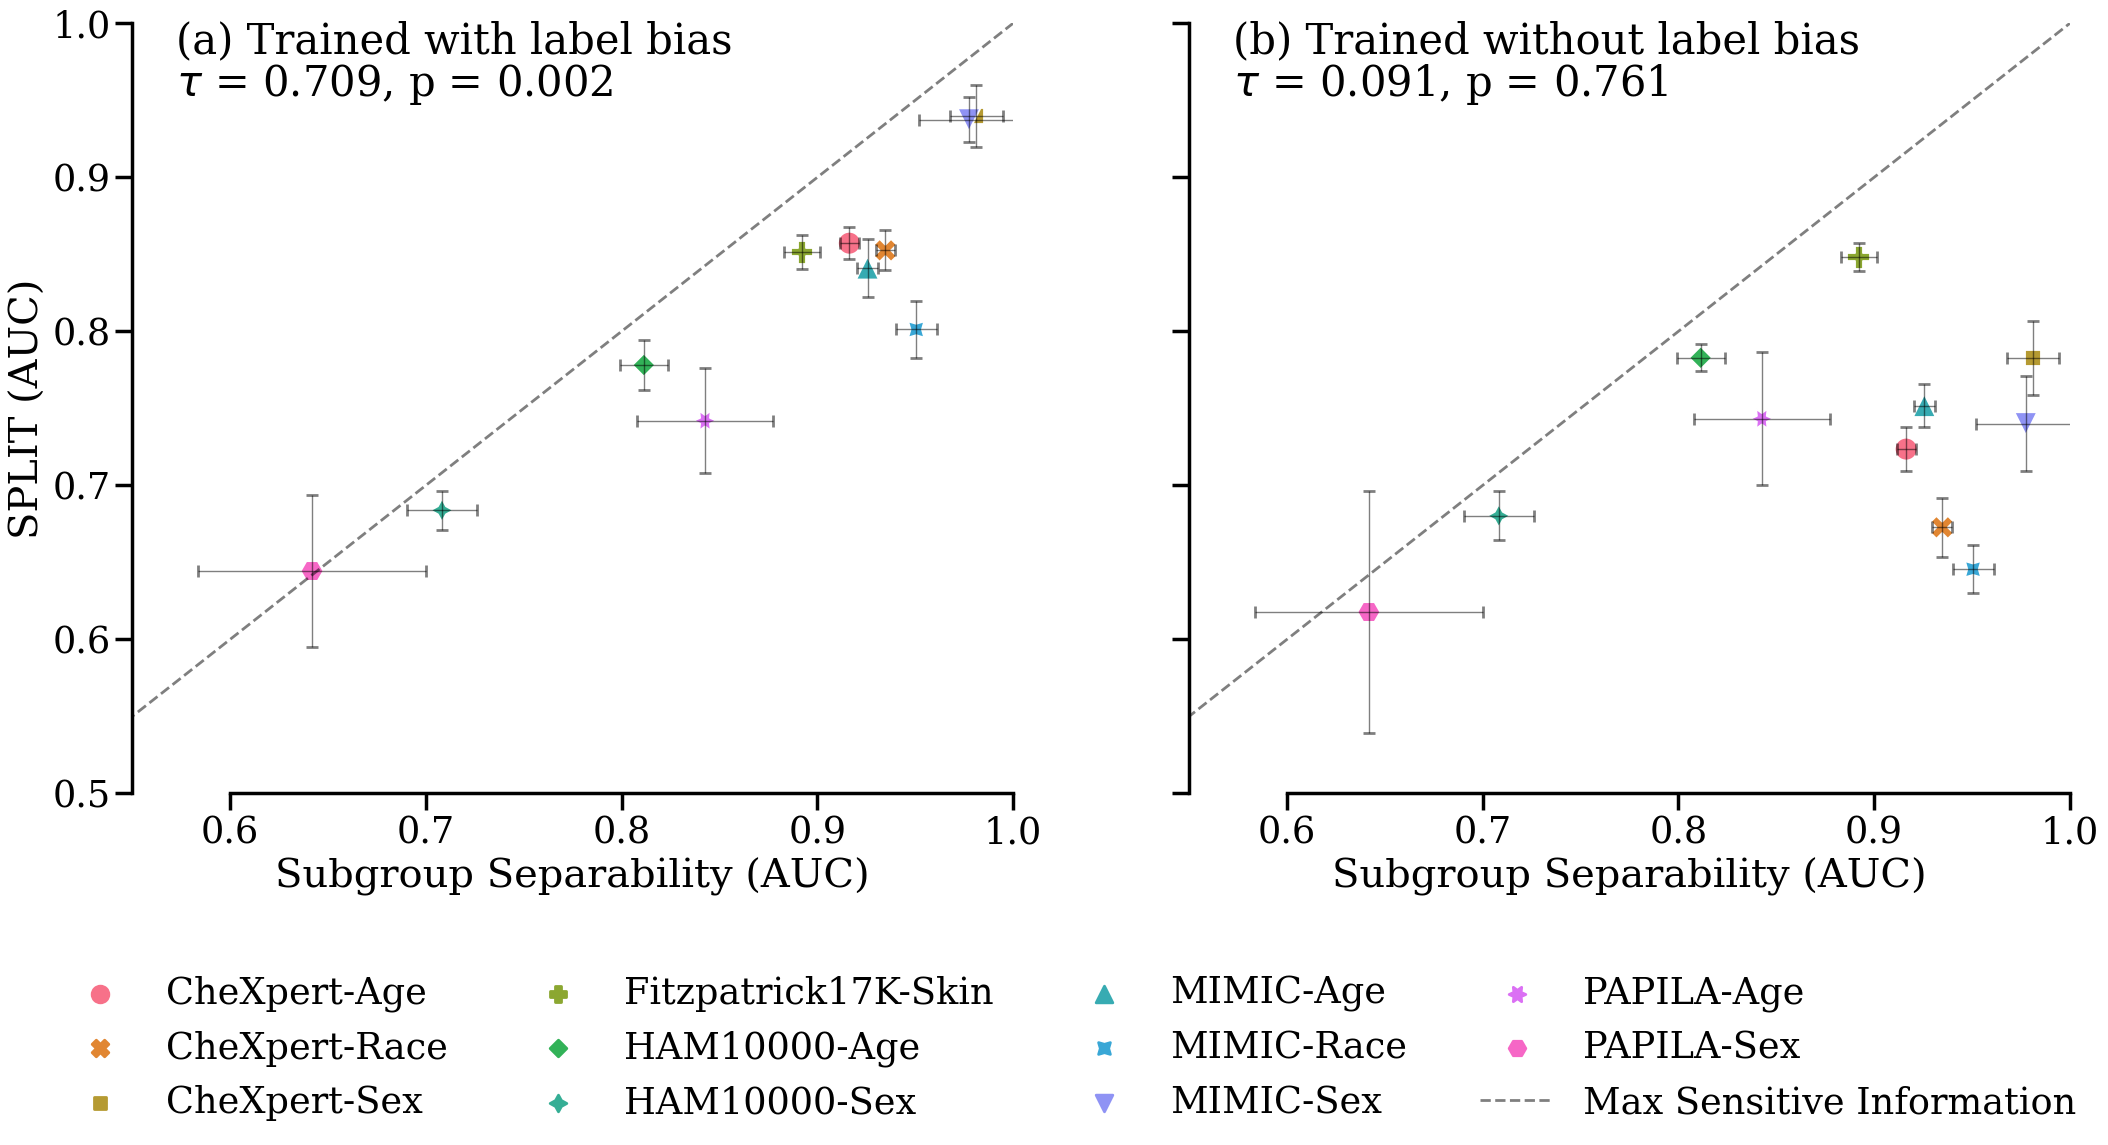

In [10]:

fig, axs = plt.subplots(1, 2, figsize=(25, 10), sharey=True)


for ax, df in zip(axs, [noise_df_agg, no_noise_df_agg]):
    plot_df = df.reset_index().copy()

    # add columns with predict_attr results
    plot_df["predict_attr_mean"] = plot_df["experiment"].map(
        attr_results_agg[("test/auc", "mean")]
    )
    plot_df["predict_attr_std"] = plot_df["experiment"].map(
        attr_results_agg[("test/auc", "std")]
    )

    # rename experiments from snake_case to Kebab-Case, capitalize first letter and after hyphen
    plot_df["experiment"] = plot_df["experiment"].map(
        {experiment: experiment.replace("_", "-").title() for experiment in plot_df["experiment"].unique()}
    )

    # rename Mimic to MIMIC, Papila to PAPILA, and Ham10000 to HAM10000, Chexpert to CheXpert
    plot_df["experiment"] = plot_df["experiment"].map(
        {experiment: experiment.replace("Mimic", "MIMIC").replace("Papila", "PAPILA").replace("Ham10000", "HAM10000").replace("Chexpert", "CheXpert") for experiment in plot_df["experiment"].unique()}
    )

    # get kendall tau correlation between predict_attr and split_test
    tau, p = stats.kendalltau(
        plot_df["predict_attr_mean"],
        plot_df["split_test/auc_mean"]
    )
    
    # add kendall tau correlation to plot
    ax.text(
        0.05, 0.95, f"$\\tau$ = {tau:.3f}, p = {p:.3f}",
        transform=ax.transAxes,
        fontsize=30,
        verticalalignment="top",
    )

    sns.scatterplot(
        data=plot_df,
        x="predict_attr_mean",
        y="split_test/auc_mean",
        hue="experiment",
        style="experiment",
        ax=ax,
        s=270,
    )

    ax.errorbar(
        x=plot_df["predict_attr_mean"],
        y=plot_df["split_test/auc_mean"],
        xerr=plot_df["predict_attr_std"],
        yerr=plot_df["split_test/auc_std"],
        fmt="none",
        ecolor="black",
        elinewidth=1,
        capsize=4,
        capthick=2,
        alpha=0.5,
    )

    # add y=x plot
    ax.plot(
        [0, 1],
        [0, 1],
        linestyle="--",
        color="black",
        alpha=0.5,
        linewidth=2,
        # add to legent
        label="Max Sensitive Information"
    )

    ax.set_xlabel("Subgroup Separability (AUC)")
    ax.set_ylabel(f"SPLIT (AUC)")

    ax.set_xlim(0.55, 1)
    ax.set_ylim(0.5, 1)



sns.despine(fig=fig, trim=True)

# share same legend for all plots
handles, labels = axs[0].get_legend_handles_labels()

# add caption to each plot
for ax, caption in zip(axs, ["(a) Trained with label bias", "(b) Trained without label bias"]):
    ax.text(
        0.05, 0.95, caption,
        transform=ax.transAxes,
        fontsize=30,
        verticalalignment="bottom",
    )

fig.legend(handles, labels, loc="lower center", ncol=4, bbox_to_anchor=(0.5,-0.25)).set_frame_on(False)


#turn off legend for all plots
for ax in axs.flat:
    ax.get_legend().remove()

# plt.savefig("test_outputs/attr_split_test.eps", bbox_inches="tight", dpi=1200, format="eps")

plt.show()
